In [17]:
import math
import time
import random
import os
import torch
from torch import nn
from d2l import torch as d2l
from matplotlib import pyplot as plt

## Download data

In [3]:
d2l.DATA_HUB['ptb'] = ('http://d2l-data.s3-accelerate.amazonaws.com/' + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

In [4]:
def read_ptb():
    """从网上下载ptb数据集"""
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

In [5]:
sentences = read_ptb()
print('Number of examples:', len(sentences))

# 在读取训练集之后，我们为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“<unk>”词元替换
vocab = d2l.Vocab(sentences, min_freq=10)
print('vocab size:', len(vocab))

Number of examples: 42069
vocab size: 6719


## Subsample frequent words

In [6]:
def subsample(sentences, vocab):
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens)

    return [[token for token in line if keep(token)] for line in sentences], counter

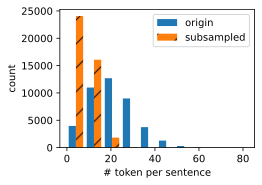

In [7]:
subsampled, counter = subsample(sentences, vocab)

d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# token per sentence', 'count', sentences, subsampled)

### Get_centers_and_contexts

In [12]:
corpus = [vocab[line] for line in subsampled]

# 中心词和上下文取词
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i-window_size), min(len(line), i+window_size+1)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

all_centers,  all_contexts = get_centers_and_contexts(corpus, 5)
print("中心词-上下文词对的数量:", sum([len(contexts) for contexts in all_contexts]))

中心词-上下文词对的数量: 1505510


In [13]:
# 负采样
class RandomGenerator:
    """根据采样权重在样本中抽取"""
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache 'k' random sampling results
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [14]:
def get_negative(all_contexts, vocab, counter, K):
    """
    随机抽取5个噪声词
    counter: token count
    vocab:
    """
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


all_negatives = get_negative(all_contexts, vocab, counter, 5)

In [15]:
# 对于每个样本，我们在contexts_negatives个变量中将其上下文词和噪声词连结起来，并填充零
# 为了在计算损失时排除填充，我们定义了掩码变量masks
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

## load data

In [16]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = 0
    sentences = read_ptb()
    # 划分成词表
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negative(all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [18]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

## model

In [22]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

In [25]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    # 通过嵌入层从词索引转化为向量
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    # batch matrix-matrix product
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

## loss function

In [19]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)


loss = SigmoidBCELoss()

## model train

In [23]:
def train(net, data_iter, lr, num_epochs):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        tik = time.time()
        num_batches = len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)/mask.sum(axis=1)*mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / (time.time()-tik):.1f} tokens/sec on {str(device)}')

loss 0.410, 75516.7 tokens/sec on cpu


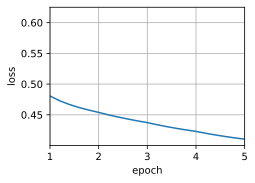

In [26]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [27]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')


get_similar_tokens('chip', 3, net[0])

cosine sim=0.715: microprocessor
cosine sim=0.713: intel
cosine sim=0.669: memory
